# Assignment 3 | Text Generation & Latent Space Visualization 

Student 1 + ID: Bashar Beshoti, 207370248

Student 2 + ID: Selan Abu Saleh, 212111439

__Introduction:__ 

This assignment explores two fascinating aspects of deep learning, 
using sequential models for text generation in natural language 
processing (NLP) and visualizing latent representations in generative 
models.

Through this assignment, you will gain hands-on experience with key 
concepts in sequence learning and a taste of generative AI, helping you 
build an intuitive understanding of model capabilities and 
representations.

## Pre-Task
Importing Libraries:

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

## Seciton 2: Latent Space Visualization

In deep learning, the latent space represents a compressed, abstract representation of input data learned by a model. Exploring this latent space helps us understand how models learn and group similar data points.

In this assignment, you will train an autoencoder to project the MNIST images into a lower-dimensional latent space, and visualize the generations as a function of latent codes.

You will then explore how these representations capture the structure of the data, and visualize the linear interpolation between different digits.

By the end of this assignment, you will better understand how neural networks encode meaningful features of input data.

### Download the given notebook from the website and download MNIST DATA.

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'data/'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The pre-processing is already written, and you only have a simple addition left for the training part.
Your task is to implement:
1. The Encoder
2. The Decoder
3. The Variational AutoEncoder
4. The Following Loss Function from scratch:
$$ \begin{aligned}
& \mathscr{L}(x, \hat{x}, \mu, \sigma)=\underbrace{\operatorname{BCE}(\hat{x}, x)}_{\text {Reconstruction Loss }}+\underbrace{-\frac{1}{2} \sum\left(1+\log \sigma^2-\mu^2-\exp \left(\log \sigma^2\right)\right)}_{\text {KL Divergence }} \\
& =-\sum[x \log (\hat{x})+(1-x) \log (1-\hat{x})]+\left(-\frac{1}{2} \sum\left[1+\log \left(\sigma^2\right)-\mu^2-\sigma^2\right]\right)
\end{aligned} $$

5. A function to generate and plot a handwritten digit
6. A function to plot the latent space
7. A linear interpolation function between 2 randomly selected digits


NOTE: you may not use pre-built loss functions from pytorch

### Encoder Class

In [3]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        log_var = self.fc2_log_var(h)
        return mean, log_var

## Decoder Class

In [4]:
class Decoder(nn.Module):

    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        x_hat = self.sigmoid(self.fc2(h))
        return x_hat

## Variational Auto Encoder Class

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2, device=device):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)
        self.device = device

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [6]:
learning_rate = 1e-3
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

## Loss Function Class


In [7]:
def loss_function(x, x_hat, mean, log_var):
    # write your code heres
    eps = 1e-8
    BCE = - torch.sum(x * torch.log(x_hat + eps) + (1 - x) * torch.log(1 - x_hat + eps))
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - torch.exp(log_var))
    return BCE + KLD

## Training Loop

In [10]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), x_dim).to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/((batch_idx+1)*x.size(0)))
        
        if (epoch + 1) % 10 == 0:
            evaluate(model, device,epoch)
            
    return overall_loss


def evaluate(model, device, epoch,x_dim=784):
    model.eval()
    with torch.no_grad():
        z = torch.zeros(2).to(device)
        sample = model.decoder(z).cpu().view(28,28)
        plt.imshow(sample, cmap='gray')
        plt.title(f"Sample reconstruction at epoch {epoch+1}")
        plt.axis('off')
        plt.show()
        model.train()

	Epoch 1 	Average Loss:  151.59152952473957
	Epoch 2 	Average Loss:  151.14231155598958
	Epoch 3 	Average Loss:  150.70346359049478
	Epoch 4 	Average Loss:  150.3327514485677
	Epoch 5 	Average Loss:  149.9848069173177
	Epoch 6 	Average Loss:  149.68097749023437
	Epoch 7 	Average Loss:  149.3664127766927
	Epoch 8 	Average Loss:  149.09141691080728
	Epoch 9 	Average Loss:  148.82702973632811
	Epoch 10 	Average Loss:  148.6075181966146


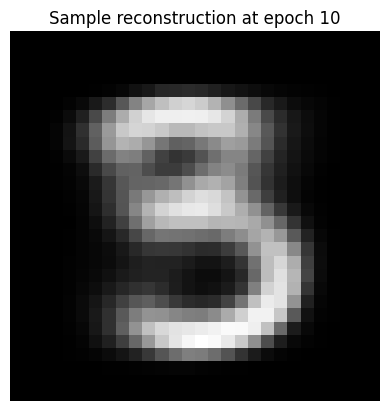

	Epoch 11 	Average Loss:  148.3569408528646
	Epoch 12 	Average Loss:  148.14185714518229
	Epoch 13 	Average Loss:  147.9693110188802
	Epoch 14 	Average Loss:  147.72409925130208
	Epoch 15 	Average Loss:  147.5445127766927
	Epoch 16 	Average Loss:  147.34765219726563
	Epoch 17 	Average Loss:  147.21044005533855
	Epoch 18 	Average Loss:  147.02037158203126
	Epoch 19 	Average Loss:  146.85137036132812
	Epoch 20 	Average Loss:  146.73264812825522


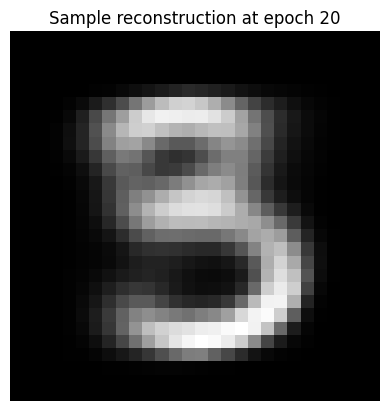

	Epoch 21 	Average Loss:  146.56019077148437
	Epoch 22 	Average Loss:  146.42154423828126
	Epoch 23 	Average Loss:  146.28454427083332
	Epoch 24 	Average Loss:  146.16753614908853
	Epoch 25 	Average Loss:  146.00003444010417
	Epoch 26 	Average Loss:  145.86679213867188
	Epoch 27 	Average Loss:  145.77912944335938
	Epoch 28 	Average Loss:  145.63975221354167
	Epoch 29 	Average Loss:  145.51563325195312
	Epoch 30 	Average Loss:  145.38911072591145


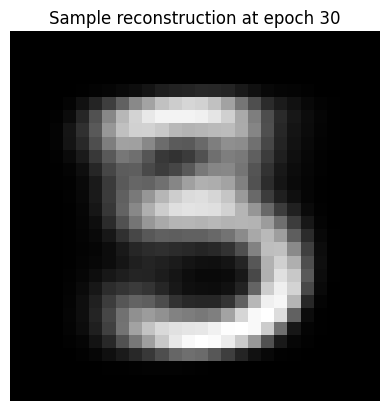

	Epoch 31 	Average Loss:  145.2450568359375
	Epoch 32 	Average Loss:  145.21037041015626
	Epoch 33 	Average Loss:  145.0763970703125
	Epoch 34 	Average Loss:  145.01839353841146
	Epoch 35 	Average Loss:  144.85940348307292
	Epoch 36 	Average Loss:  144.7846286295573
	Epoch 37 	Average Loss:  144.6734911783854
	Epoch 38 	Average Loss:  144.60742799479166
	Epoch 39 	Average Loss:  144.4957025390625
	Epoch 40 	Average Loss:  144.4105124186198


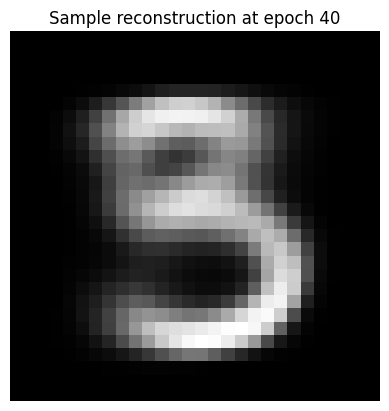

	Epoch 41 	Average Loss:  144.3712612955729
	Epoch 42 	Average Loss:  144.2582514160156
	Epoch 43 	Average Loss:  144.18853046875
	Epoch 44 	Average Loss:  144.1581158528646
	Epoch 45 	Average Loss:  144.00178180338543
	Epoch 46 	Average Loss:  143.97610522460937
	Epoch 47 	Average Loss:  143.87922403971353
	Epoch 48 	Average Loss:  143.84380333658854
	Epoch 49 	Average Loss:  143.803344140625
	Epoch 50 	Average Loss:  143.6528837076823


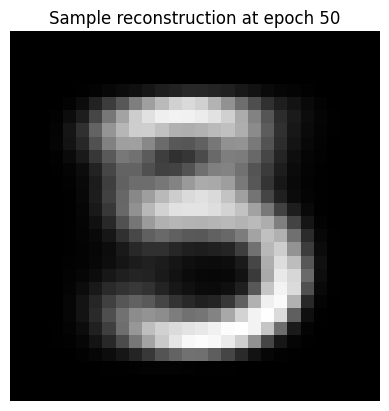

total loss is:  8619173.022460938


In [11]:
print("total loss is: ",train(model, optimizer, epochs=50, device=device))

## Generate and plot digit

In [12]:
def generate_digit(mean, var):
    latent_dim = model.encoder.fc2_mean.out_features
    latent = torch.normal(mean=torch.full((latent_dim,), mean), std=torch.full((latent_dim,), var)).to(device)
    with torch.no_grad():
        model.eval()
        digit = model.decoder(latent).cpu().view(28, 28)
    def plot_digit():
        plt.imshow(digit, cmap="gray")
        plt.title(f"Generated digit with latent vector: [{mean}, {var}]")
        plt.axis('off')
        plt.show()
    return plot_digit

In [13]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

(<function __main__.generate_digit.<locals>.plot_digit()>,
 <function __main__.generate_digit.<locals>.plot_digit()>)

## Latent Space Grid Visualization

In [14]:
def plot_latent_space(model, scale, digit_size=28, figsize=15, grid_size=15):
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size))
    grid_x = np.linspace(-scale, scale, grid_size)
    grid_y = np.linspace(-scale, scale, grid_size)[::-1]
    
    with torch.no_grad():
        model.eval()
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z = torch.zeros(model.encoder.fc2_mean.out_features).to(device)
                z[0] = xi
                z[1] = yi
                x_hat = model.decoder(z).cpu().numpy()
                digit = x_hat.reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = grid_size * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.title("Latent Space Visualization")
    plt.show()

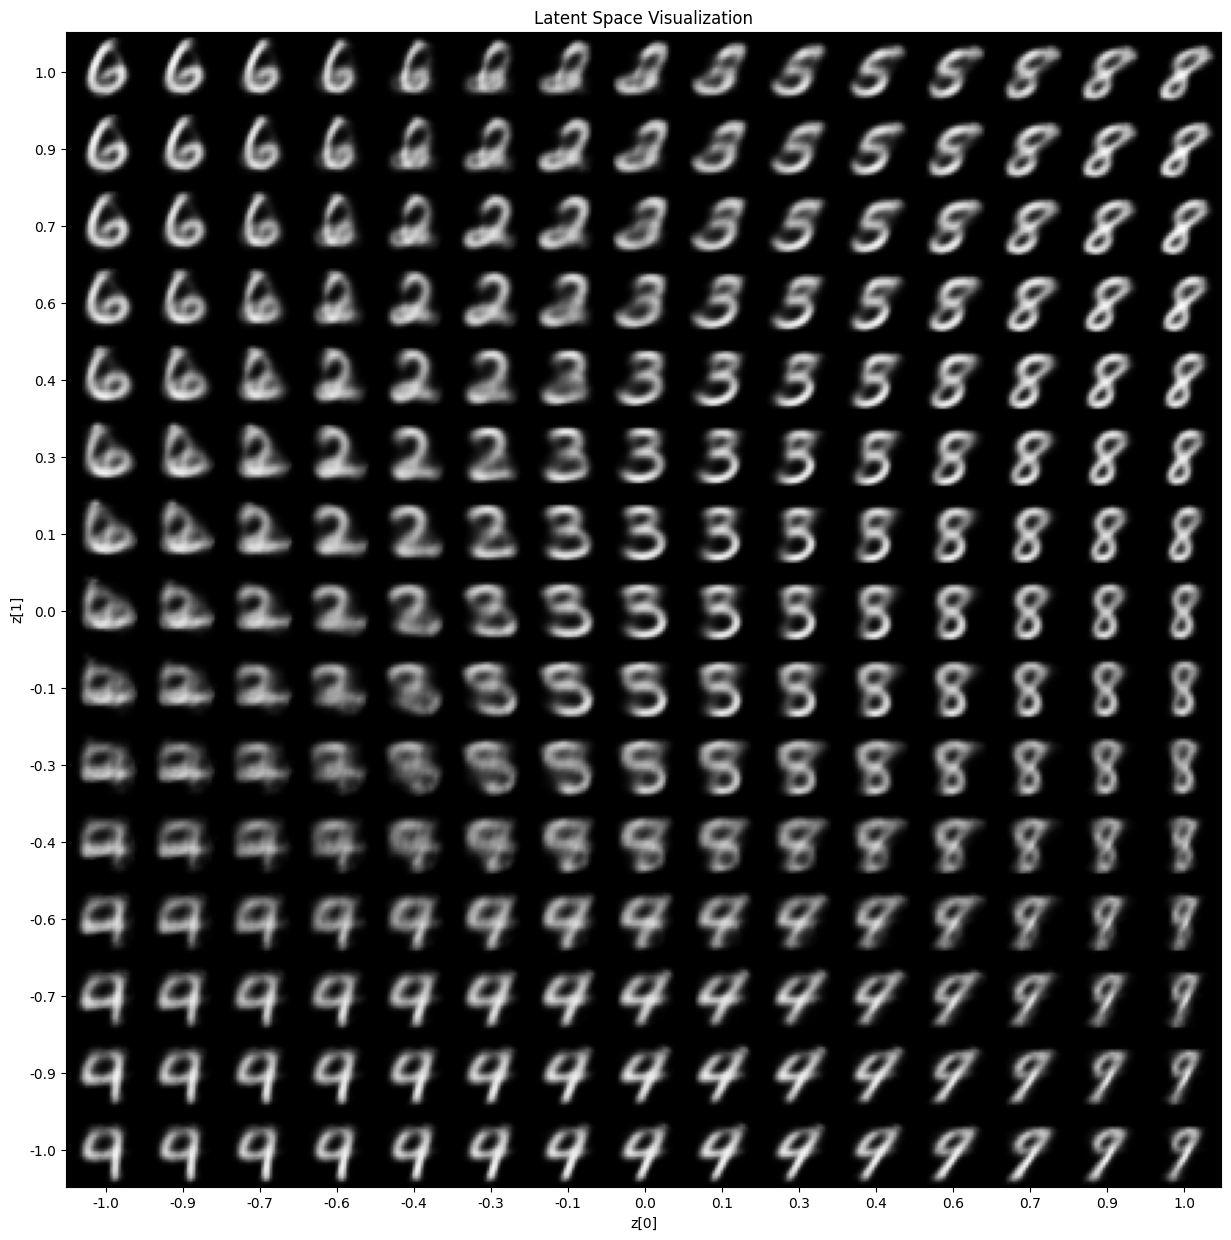

In [15]:
plot_latent_space(model, scale=1.0)

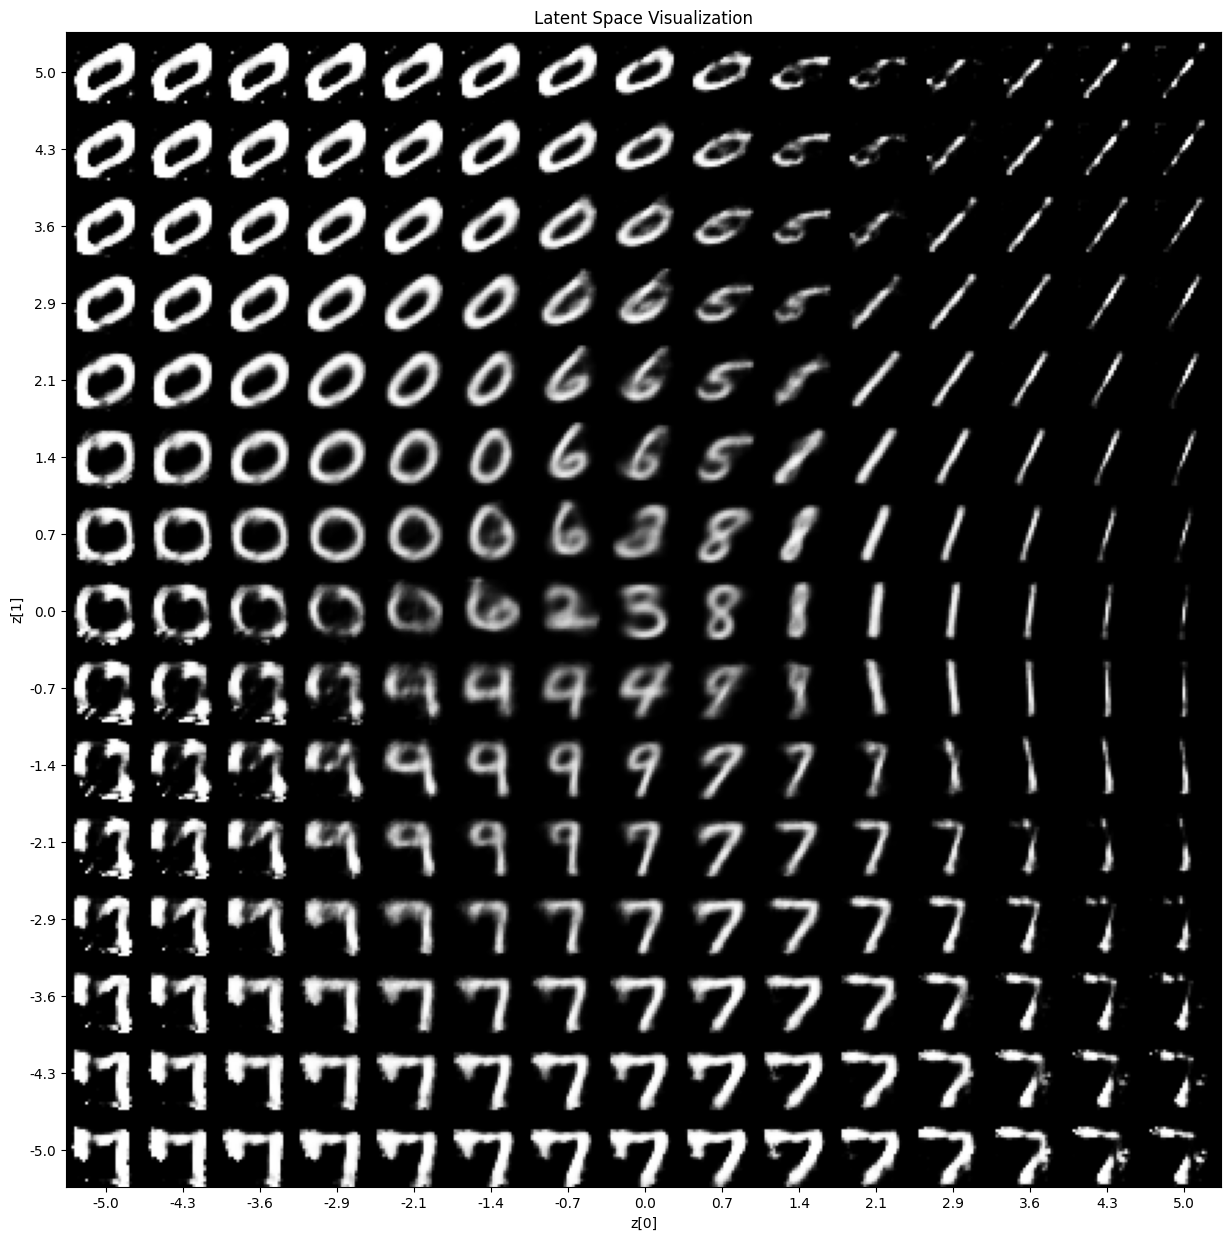

In [16]:
plot_latent_space(model, scale=5.0)

## Linear Interpolation

In [17]:
# write your code here
def linear_interpolation(model, num_steps=10):
    test_loader_iter = iter(test_loader)
    images, labels = next(test_loader_iter)
    labels_np = labels.numpy()
    unique_labels = np.unique(labels_np)
    
    l1, l2 = np.random.choice(unique_labels, size=2, replace=False)
    idx1 = (labels == l1).nonzero()[0].item()
    idx2 = (labels == l2).nonzero()[0].item()
    
    img1 = images[idx1].view(-1, 784).to(device)
    img2 = images[idx2].view(-1, 784).to(device)
    
    with torch.no_grad():
        model.eval()
        mean1, log_var1 = model.encoder(img1)
        z1 = model.reparameterize(mean1, log_var1)
        mean2, log_var2 = model.encoder(img2)
        z2 = model.reparameterize(mean2, log_var2)
    
    interpolation = []
    for t in np.linspace(0, 1, num_steps):
        z = (1 - t) * z1 + t * z2
        x_hat = model.decoder(z).detach().cpu().view(28, 28).numpy()
        interpolation.append(x_hat)
    
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 2))
    for i, ax in enumerate(axes):
        ax.imshow(interpolation[i], cmap="gray")
        ax.axis('off')
        ax.set_title(f"{(i/(num_steps-1)):.2f}")
    plt.suptitle(f"Linear Interpolation between digits {l1} and {l2}")
    plt.show()

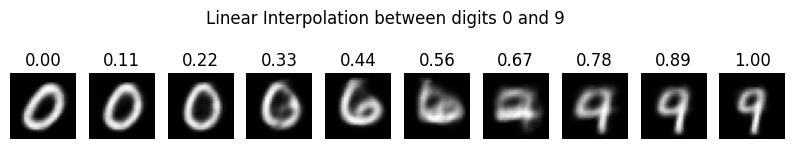

In [18]:
linear_interpolation(model, num_steps=10)

## Summary

### Parameters and Variables

In [20]:
print("Parameters and Variables:\n")

print(f"batch_size: {batch_size}")
print(f"device: {device}")
print(f"learning_rate: {learning_rate}")
print(f"model: {model}")
print(f"optimizer: {optimizer}")
print(f"path: {path}")
print(f"test_dataset: {test_dataset}")
print(f"test_loader: {test_loader}")
print(f"train_dataset: {train_dataset}")
print(f"train_loader: {train_loader}")
print(f"transform: {transform}")

Parameters and Variables:

batch_size: 100
device: cpu
learning_rate: 0.001
model: VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2_mean): Linear(in_features=400, out_features=2, bias=True)
    (fc2_log_var): Linear(in_features=400, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
path: data/
test_dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
test_loader: <torch.utils.data.dataloader

### Neural Network Summary

In [21]:
# import torchsummary
# Print the model summary
# torchsummary.summary(model, (seq_length, 1))
print("Model Summary:\n")
print(model)

print("Parameters count:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Model Summary:

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2_mean): Linear(in_features=400, out_features=2, bias=True)
    (fc2_log_var): Linear(in_features=400, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)
Parameters count: 631188
